### Import the necessary libraries

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [2]:
df = gpd.read_file('../data/processed/high_res.shp')

### Predict only using population density and HDI

In [3]:
#fit random forest model
X = df[['Pop_den', "HDI"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df["Province"])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

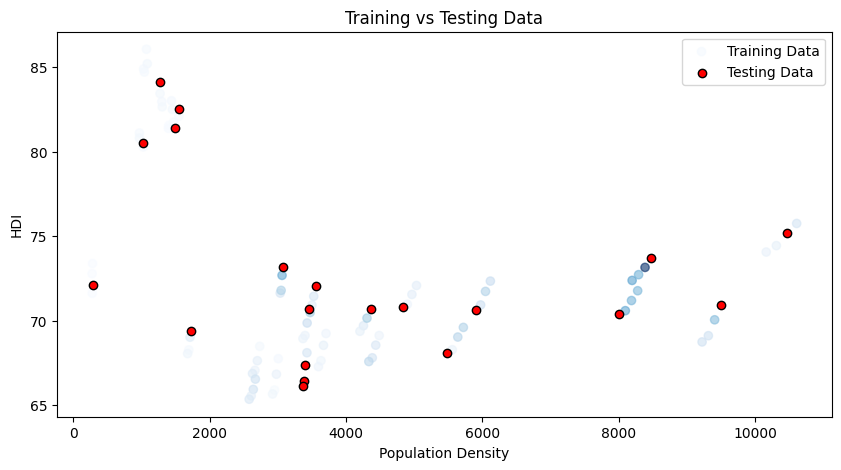

In [4]:
#To-do: plot training and testing data (One showing training points and another that shows testing points) with the prediction values
# Plot training and testing data
plt.figure(figsize=(10, 5))

# Scatter plot for Training Data
plt.scatter(X_train['Pop_den'], X_train['HDI'], c=y_train, cmap='Blues', label='Training Data', alpha=0.6)

# Scatter plot for Testing Data
plt.scatter(X_test['Pop_den'], X_test['HDI'], c='red', label='Testing Data', edgecolors='k')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.legend()
plt.title('Training vs Testing Data')
plt.show()

In [5]:
# Create new dataset with NaN for testing 'Cases'
df_modified = df.copy()
df_modified.loc[test_index, 'Cases'] = np.nan  # Replace testing 'Cases' with NaN

# Save the dataset
df_modified.to_csv('../data/processed/df_aggVAE_rf_training_comparison.csv', index=False)

df_pointer = df.copy()
df_pointer["split"] = "train"
df_pointer.loc[test_index, 'split'] = 'test'

df_pointer.to_csv('../data/processed/df_aggVAE_rf_split.csv', index=False)

In [6]:
#in VAE: give counts of the training points in the random forest --> during VAE inference also pass the values of the district case counts
#in vae prevalence model: u provide data for the districts in which rf is being trained on. 

In [7]:
#OOB error to find the optimal n_estimators, with 500, 1000 trees; (dont need to tune max_features first)
# Define your random forest regressor
rf = RandomForestRegressor(oob_score=True, random_state=42)

# Set up the grid search parameters for n_estimators
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Adjust as needed
}

# Set up GridSearchCV with oob_score
grid_search = GridSearchCV(rf, param_grid, cv=None, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees (n_estimators)
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal n_estimators: {best_n_estimators}")

# Access the best OOB score
best_oob_score = grid_search.best_estimator_.oob_score_
print(f"Best OOB score: {best_oob_score}")

Optimal n_estimators: 1000
Best OOB score: 0.6518537559010162


In [8]:
#compute the predictions and then append the predictions to the df, then extract the df out
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [9]:
# Add the predictions to the test set (preserving indices)
X_test['Predicted_Cases'] = y_pred

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

         District           x         y  Year  Area_sq_km    HDI    Province  \
0         BANDUNG  107.610841 -7.099969  2020     1767.96  72.39  Jawa Barat   
1         BANDUNG  107.610841 -7.099969  2021     1767.96  72.73  Jawa Barat   
2         BANDUNG  107.610841 -7.099969  2022     1767.96  73.16  Jawa Barat   
3         BANDUNG  107.610841 -7.099969  2023     1767.96  73.74  Jawa Barat   
4   BANDUNG BARAT  107.414953 -6.897056  2020     1305.77  68.08  Jawa Barat   
..            ...         ...       ...   ...         ...    ...         ...   
91       SUMEDANG  107.980850 -6.825066  2023     1518.33  73.18  Jawa Barat   
92    TASIKMALAYA  108.141296 -7.496706  2020     2551.19  65.67  Jawa Barat   
93    TASIKMALAYA  108.141296 -7.496706  2021     2551.19  65.90  Jawa Barat   
94    TASIKMALAYA  108.141296 -7.496706  2022     2551.19  66.84  Jawa Barat   
95    TASIKMALAYA  108.141296 -7.496706  2023     2551.19  67.76  Jawa Barat   

    Cases  Population      Pop_den  \
0

In [10]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf_popden_hdi.csv")

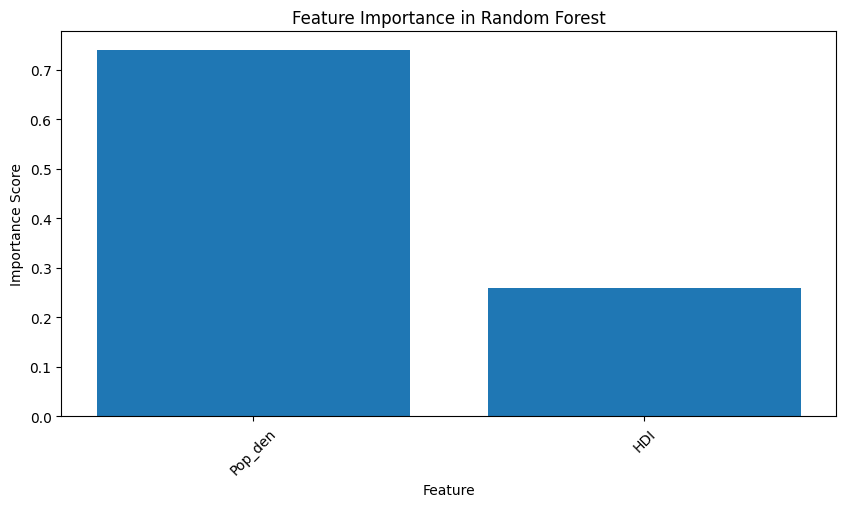

In [11]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [12]:
# Save the model
with open("../model_weights/rf/random_forest_model_pop_den_hdi.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)

### Predict with all covariates 

In [14]:
# Convert 'District' and 'Province' columns to categorical
df['District'] = df['District'].astype('category')
df['Province'] = df['Province'].astype('category')

# Encode the categories as numbers
df['District_encoded'] = df['District'].cat.codes
df['Province_encoded'] = df['Province'].cat.codes

In [15]:
df.head()

,District,x,y,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,geometry,District_encoded,Province_encoded
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,Jawa Barat,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0,1
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,Jawa Barat,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0,1
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,Jawa Barat,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0,1
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,Jawa Barat,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0,1
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,Jawa Barat,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",1,1


In [16]:
#fit random forest model
X = df.drop(columns = ["Cases", "District", "Province", "geometry"])  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=38, stratify=df["Province"])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

In [17]:
#OOB error to find the optimal n_estimators, with 500, 1000 trees; (dont need to tune max_features first)
# Define your random forest regressor
rf = RandomForestRegressor(oob_score=True, random_state=42)

# Set up the grid search parameters for n_estimators
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Adjust as needed
}

# Set up GridSearchCV with oob_score
grid_search = GridSearchCV(rf, param_grid, cv=None, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees (n_estimators)
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal n_estimators: {best_n_estimators}")

# Access the best OOB score
best_oob_score = grid_search.best_estimator_.oob_score_
print(f"Best OOB score: {best_oob_score}")

Optimal n_estimators: 1000
Best OOB score: 0.6705899982677241


In [19]:
#compute the predictions and then append the predictions to the df, then extract the df out
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [20]:
# Add the predictions to the test set (preserving indices)
X_test['Predicted_Cases'] = y_pred

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

         District           x         y  Year  Area_sq_km    HDI    Province  \
0         BANDUNG  107.610841 -7.099969  2020     1767.96  72.39  Jawa Barat   
1         BANDUNG  107.610841 -7.099969  2021     1767.96  72.73  Jawa Barat   
2         BANDUNG  107.610841 -7.099969  2022     1767.96  73.16  Jawa Barat   
3         BANDUNG  107.610841 -7.099969  2023     1767.96  73.74  Jawa Barat   
4   BANDUNG BARAT  107.414953 -6.897056  2020     1305.77  68.08  Jawa Barat   
..            ...         ...       ...   ...         ...    ...         ...   
91       SUMEDANG  107.980850 -6.825066  2023     1518.33  73.18  Jawa Barat   
92    TASIKMALAYA  108.141296 -7.496706  2020     2551.19  65.67  Jawa Barat   
93    TASIKMALAYA  108.141296 -7.496706  2021     2551.19  65.90  Jawa Barat   
94    TASIKMALAYA  108.141296 -7.496706  2022     2551.19  66.84  Jawa Barat   
95    TASIKMALAYA  108.141296 -7.496706  2023     2551.19  67.76  Jawa Barat   

    Cases  Population      Pop_den  \
0

In [21]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf_all.csv")

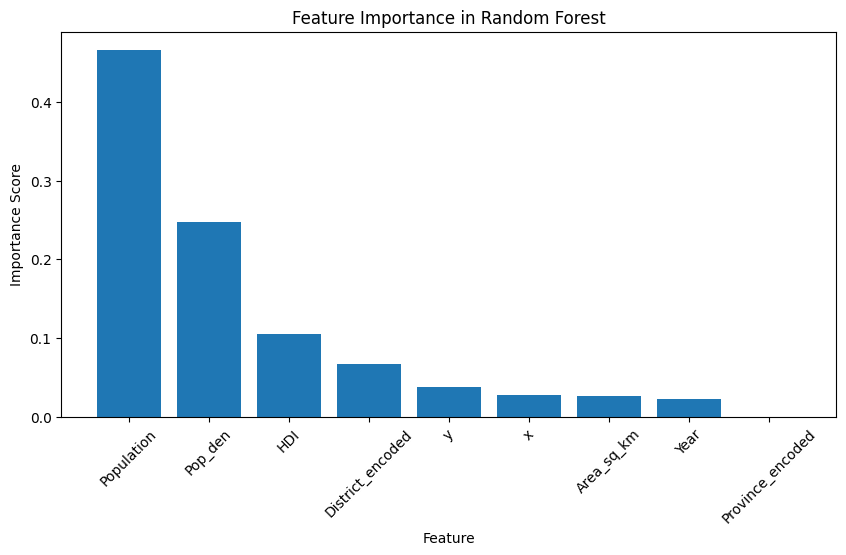

In [22]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()